# Natural Language Processing 

In this workshop, we will try out different NLP methods. We will learn how to preprocess text, and how it affects the outcomes of the methods.

We will do so by applying NLP to a dataset of Trump Twitter messages. 

You will also get to make sure that you have all the required packages and that they run properly. You may find that some of the packages will require some fiddling, in particular visualization in Jupyter with BERTopic. 

The type of preprocessing needed varies between methods, and the preprocessing can affect the result in important and not always easily predictable ways.

We will look at different NLP tasks, such as sentiment analysis, topic modeling, and machine learning, and your task will be to find how to preprocess the data to produce the best outcomes.



In [1]:
import pandas as pd

In [3]:
#Let's load the data
df = pd.read_csv('trumptweets.csv')


## Overview of data

Let's start by getting a feeling for the data, through some simple descriptive statistics.

In [70]:
# Some example messages
df.head()

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged,month,year
0,98454970654916608,Republicans and Democrats have both created ou...,f,f,TweetDeck,49,255,2011-08-02 18:07:48,f,2011-08-01,2011
1,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03 01:34:50,f,2020-03-01,2020
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12 20:10:58,f,2020-09-01,2020
6,1223640662689689602,Getting a little exercise this morning,f,f,Twitter for iPhone,285863,30209,2020-02-01 16:14:02,f,2020-02-01,2020
7,1319501865625784320,,f,f,Twitter for iPhone,130822,19127,2020-10-23 04:52:14,f,2020-10-01,2020


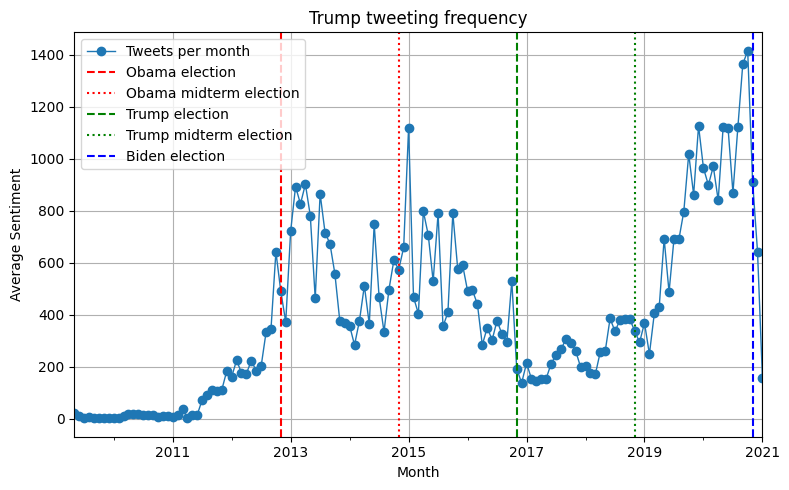

In [34]:
# Plot posting frequency over time

import matplotlib.pyplot as plt

df['month'] = df.date.str[:7]+'-01'
df['month'] = pd.to_datetime(df['month']) 
fig, ax = plt.subplots(figsize=(8,5))

# Group the posts per month, then count, and plot the result!
df.groupby(['month'])['id'].count().plot(ax=ax, marker='o', lw=1,label='Tweets per month')

# Some style
ax.set_xlabel('Month')
ax.set_ylabel('Average Sentiment')
ax.set_title("Trump tweeting frequency")

# Let's add vertical lines for the elections
ax.axvline('2012-11-06', color='red', linestyle='--',label='Obama election')
ax.axvline('2014-11-06', color='red', linestyle=':',label='Obama midterm election')
ax.axvline('2016-11-08', color='green', linestyle='--',label='Trump election')
ax.axvline('2018-11-06', color='green', linestyle=':',label='Trump midterm election')
ax.axvline('2020-11-03', color='blue', linestyle='--',label='Biden election')

ax.grid(True)
fig.tight_layout()

plt.legend()
plt.show()

## Preprocessing the text for NLP
Preprocessing can involve some combination of the following steps. Which steps to use depends on what you want to do.

1. *Remove unwanted or empty messages.* We start by cleaning the data, removing messages that are unlikely to contain any useful text.

2. *Text Cleaning.*
The first step is to clean the text. We remove any irrelevant items like HTML tags, URLs, and codes when dealing with web data. We also get rid of special characters, numbers, or punctuation that might not be necessary for analysis.

3. *Case Normalization.*
Next, we normalize the case by converting all the text to lower case. This ensures that words like 'House', 'house', and 'HOUSE' are all treated as the same word, preventing the model from treating them as different entities.

4. *Tokenization.*
Then we move to tokenization. This is where we break down the text into smaller pieces, or tokens. Tokens can be words, phrases, or even sentences. In English, this might seem as simple as splitting by spaces, but it can get complicated with languages that don’t use spaces or have complex morphology.

5. *Stop Words Removal.*
After tokenization, we often remove stop words. These are common words like 'is', 'and', 'the', which appear frequently in the text but usually don’t carry significant meaning for the analysis.

6. *Lemmatization.*
Now, we refine our tokens using ste lemmatization. This strips the words down to their root form. For example, 'running', 'runs', and 'ran' might all be reduced to 'run'.

But what steps makes sense depends on the task at hand!


### 1. Remove empty or unwanted messages
We should always start by cleaning the data, removing messages that are unlikely to contain any useful text.

We are interested in what Trump is saying, so we remove retweets and quote tweets.

In [5]:
def clean_data(df):
    # Remove retweets
    df = df.loc[df['isRetweet']=='f']
    # Messages that start with """ are qoute tweets
    df = df.loc[(~df.text.str.startswith('"RT @'))&(~df.text.str.startswith('RT @'))&(~df.text.str.startswith('"""'))]
    return df.copy()

In [6]:
print(f"Before cleaning: {len(df)} rows")
df = clean_data(df)
print(f"After cleaning: {len(df)} rows")

Before cleaning: 56571 rows
After cleaning: 35004 rows


Let's define functions for cleaning up the text content for processing!

### 2. Text cleaning: Remove HTML tags, URLs, numbers, etc.

We can then clean up the text itself, removing URLs and hashtags. 

In [37]:
import re

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove hashtags (but keep the word following the hashtag)
    text = re.sub(r'#', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Remove additional white spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Example usage:
sample_text = '''So now the Fake News @nytimes is tracing the CoronaVirus origins back to Europe, NOT China. This is a first! #fakenews
I wonder what the Failing New York Times got for this one? Are there any NAMED sources? They were recently thrown out of China like dogs, 
and obviously want back in. Sad! https://t.co/4qwCKQOiOw'''

text = clean_text(sample_text)
print(text)

So now the Fake News nytimes is tracing the CoronaVirus origins back to Europe NOT China This is a first fakenews I wonder what the Failing New York Times got for this one Are there any NAMED sources They were recently thrown out of China like dogs and obviously want back in Sad


### 3. Case normalization

Let's make everything lower-case. 

In [38]:
def case_normalization(text):
    return text.lower()
text = case_normalization(text)
print(text)

so now the fake news nytimes is tracing the coronavirus origins back to europe not china this is a first fakenews i wonder what the failing new york times got for this one are there any named sources they were recently thrown out of china like dogs and obviously want back in sad


### 4. Tokenization: Split into a list of words

In [39]:
def tokenization(text):
    return text.split()
    
tokens = tokenization(text)
print(tokens)

['so', 'now', 'the', 'fake', 'news', 'nytimes', 'is', 'tracing', 'the', 'coronavirus', 'origins', 'back', 'to', 'europe', 'not', 'china', 'this', 'is', 'a', 'first', 'fakenews', 'i', 'wonder', 'what', 'the', 'failing', 'new', 'york', 'times', 'got', 'for', 'this', 'one', 'are', 'there', 'any', 'named', 'sources', 'they', 'were', 'recently', 'thrown', 'out', 'of', 'china', 'like', 'dogs', 'and', 'obviously', 'want', 'back', 'in', 'sad']


###  5. Remove stopwords

In [40]:
# We use a predefined list of stopwords

stopwordlist = set(['i','me','my','myself','we','our','ours','ourselves','you','your','yours','yourself','yourselves','he','him','his','himself','she','her','hers','herself','it','its','itself','they','them','their','theirs','themselves','what','which','who','whom','this','that','these','those','am','is','are','was','were','be','been','being','have','has','had','having','do','does','did','doing','a','an','the','and','but','if','or','because','as','until','while','of','at','by','for','with','about','against','between','into','through','during','before','after','above','below','to','from','up','down','in','out','on','off','over','under','again','further','then','once','here','there','when','where','why','how','all','any','both','each','few','more','most','other','some','such','no','nor','not','only','own','same','so','than','too','very','s','t','can','will','just','don','should','now'])
def remove_stopwords(tokens):
    return [token for token in tokens if token not in stopwordlist]

tokens = remove_stopwords(tokens)
print(tokens)

['fake', 'news', 'nytimes', 'tracing', 'coronavirus', 'origins', 'back', 'europe', 'china', 'first', 'fakenews', 'wonder', 'failing', 'new', 'york', 'times', 'got', 'one', 'named', 'sources', 'recently', 'thrown', 'china', 'like', 'dogs', 'obviously', 'want', 'back', 'sad']


### 6. Lemmatization
Lemmatization involves the use of vocabulary and morphological analysis to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma.

In [41]:
!pip3 install nltk
!python3 -m nltk.downloader punkt
# !python3 -m nltk.downloader wordnet 

In [42]:
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize(tokens):
    # Perform lemmatization
    return [lemmatizer.lemmatize(token) for token in tokens]

lemmatized_words = lemmatize(tokens)
print("Lemmatized Tokens:", lemmatized_words)
tokens = lemmatized_words

Lemmatized Tokens: ['fake', 'news', 'nytimes', 'tracing', 'coronavirus', 'origin', 'back', 'europe', 'china', 'first', 'fakenews', 'wonder', 'failing', 'new', 'york', 'time', 'got', 'one', 'named', 'source', 'recently', 'thrown', 'china', 'like', 'dog', 'obviously', 'want', 'back', 'sad']


## Exercise 1:
Run all  of text preprocessing steps on a sample of Trump tweets and print the results after each step!

[Go to Solution](#exercise1)


In [54]:
# A sample of 10 Trump tweets
dd = df.sample(10)
dd = clean_data(dd)

print("Original:")
print(list(dd['text']))

# We first clean the text
print("Clean text:")
dd['text'] = dd['text'].apply(clean_text)
print(list(dd['text']))

print("Clean text:")
dd['text'] = dd['text'].apply(tokenization)
print(list(dd['text']))



# Apply each function on the dataframe, and print the result
# [Your code here]


Original:
['....a look, the facts speak far louder than words! The Democrats always play the Race Card, when in fact they have done so little for our Nation’s great African American people. Now, lowest unemployment in U.S. history, and only getting better. Elijah Cummings has failed badly!', '@JackieDee16 @CelebApprentice  March 3rd 9 pm EST on NBC', 'I will be interviewed on @foxandfriends at 8:40. A.M. Enjoy!', 'Obama has zero credibility on oil and coal. If we do not win energy as a country, we just do not win, period!', 'On my way to South Carolina. Big Crowd--- look forward to it!', 'It’s Monday. How many fundraisers will Obama hold today?', 'Proud of Mike! https://t.co/g1HvItV79N', 'BUILD A WALL &amp, CRIME WILL FALL! This is the new theme, for two years until the Wall is finished (under construction now), of the Republican Party. Use it and pray!', '.@lancearmstrong, revise your decision to quit--go back and fight.', 'I want to end the day by saying there is no check I would rat

# Text representation

### 1. Bag-of-words (BoW)
The Bag-of-Words model is one of the simplest forms of text representation. Imagine dumping all the words from a text into a bag. Each word becomes a feature of the text. In BoW, the order of words is ignored; what matters is the frequency of each word in the text. The main advantage of BoW is its simplicity and ease of understanding. It's quite effective for tasks like spam detection where word presence significantly influences the outcome. However, its simplicity can also be a drawback since it ignores syntax and semantics, which can lead to a loss of context and meaning.

In [57]:
#Counter is a simple function that simply counts the occurrances of objects in lists
from collections import Counter
Counter(["Hey","Jude","don't","make","it","bad",
         "Na","na","na","nananana,","nannana,","hey","Jude",
        "Na","na","na","nananana,","nannana,","hey","Jude"])
        


Counter({'na': 4,
         'Jude': 3,
         'Na': 2,
         'nananana,': 2,
         'nannana,': 2,
         'hey': 2,
         'Hey': 1,
         "don't": 1,
         'make': 1,
         'it': 1,
         'bad': 1})

In [58]:
# So we can use it to create a bag-of-words
def bag_of_words(tokens):
    return Counter(tokens)

bag_of_words(tokens)

Counter({'back': 2,
         'china': 2,
         'fake': 1,
         'news': 1,
         'nytimes': 1,
         'tracing': 1,
         'coronavirus': 1,
         'origin': 1,
         'europe': 1,
         'first': 1,
         'fakenews': 1,
         'wonder': 1,
         'failing': 1,
         'new': 1,
         'york': 1,
         'time': 1,
         'got': 1,
         'one': 1,
         'named': 1,
         'source': 1,
         'recently': 1,
         'thrown': 1,
         'like': 1,
         'dog': 1,
         'obviously': 1,
         'want': 1,
         'sad': 1})

### 2. TF-IDF (Term-Frequency-Inverse Document Frequency)
TF-IDF improves upon the BoW model by considering not just the frequency of a word in a single document (Term Frequency) but also how unique the word is across all documents in the corpus (Inverse Document Frequency). 

Common words that appear in many documents (like 'the') are given less weight, while rare words are emphasized. This method is more informative than BoW and is particularly useful in search engines and information retrieval. Its limitation, however, is that it still treats words as independent features and does not account for word order or context.

In [62]:
# This code calculates the TF-IDF
# Read through and make sure you understand it

import math
from collections import Counter

def compute_tf(documents):
    """
    Compute the term frequency for each document in the raw_documents list.
    
    Parameters:
    - documents (list of list of str): A list of list of strings, repsenting the tokens of the documnets.
    
    Returns:
    - list of Counter: A list where each item is a Counter object with the term frequency of each term in the document.
    """
    tf_documents = []
    for document in documents:
        # Count the frequency of each term in the document
        tf_documents.append(Counter(document))
    return tf_documents

def compute_idf(tf_documents):
    """
    Compute the inverse document frequency for all terms in the tf_documents.
    
    Parameters:
    - tf_documents (list of Counter): A list of Counter objects for term frequencies in each document.
    
    Returns:
    - dict: A dictionary with terms as keys and their IDF as values.
    """
    # Count the number of documents that contain each term
    df = Counter()
    for tf in tf_documents:
        for term in tf.keys():
            df[term] += 1
    
    # Compute the IDF for each term
    idf = {}
    total_documents = len(tf_documents)
    for term, count in df.items():
        # Apply the IDF formula
        idf[term] = math.log(total_documents / float(count))
    return idf

def compute_tf_idf_manual(documents):
    """
    Manually compute the TF-IDF for a list of raw documents.
    
    Parameters:
    - raw_documents (list of list of str): A list of list of str tokens for which the TF-IDF is computed.
    
    Returns:
    - list of dict: A list where each item is a dictionary with terms as keys and their TF-IDF as values.
    """
    # First compute the term frequency for each document
    tf_documents = compute_tf(documents)
    # Then compute the inverse document frequency for all terms
    idf = compute_idf(tf_documents)
    
    # Now compute the TF-IDF for each term in each document
    tf_idf_documents = []
    for tf in tf_documents:
        tf_idf = {}
        for term, frequency in tf.items():
            # Multiply term frequency by inverse document frequency
            tf_idf[term] = frequency * idf[term]
        tf_idf_documents.append(tf_idf)
    
    return tf_idf_documents

# Sort the dictionary by value in descending order and select the top N items
def get_highest_values(input_dict, N=1):
    return sorted(input_dict.items(), key=lambda item: item[1], reverse=True)[:N]




In [64]:
# Example usage of our new functions!
example_text_list = [
    "The quick brown fox jumps over the lazy dog",
    "Never jump over the lazy dog quickly",
    "Bright vixens jump; dozy fowl quack",
    "Quick wafting zephyrs vex bold Jim"
]

# The tf_idf function takes tokens, so we have to first tokenize our documents. 
# Let's use the function we created earlier
documents = [tokenization(document) for document in example_text_list]

# Compute TF-IDF manually
tf_idf_manual = compute_tf_idf_manual(documents)
tf_idf_manual

[{'The': 1.3862943611198906,
  'quick': 1.3862943611198906,
  'brown': 1.3862943611198906,
  'fox': 1.3862943611198906,
  'jumps': 1.3862943611198906,
  'over': 0.6931471805599453,
  'the': 0.6931471805599453,
  'lazy': 0.6931471805599453,
  'dog': 0.6931471805599453},
 {'Never': 1.3862943611198906,
  'jump': 1.3862943611198906,
  'over': 0.6931471805599453,
  'the': 0.6931471805599453,
  'lazy': 0.6931471805599453,
  'dog': 0.6931471805599453,
  'quickly': 1.3862943611198906},
 {'Bright': 1.3862943611198906,
  'vixens': 1.3862943611198906,
  'jump;': 1.3862943611198906,
  'dozy': 1.3862943611198906,
  'fowl': 1.3862943611198906,
  'quack': 1.3862943611198906},
 {'Quick': 1.3862943611198906,
  'wafting': 1.3862943611198906,
  'zephyrs': 1.3862943611198906,
  'vex': 1.3862943611198906,
  'bold': 1.3862943611198906,
  'Jim': 1.3862943611198906}]

### 3. Word Embeddings
Word Embeddings are a more advanced technique where words are mapped to vectors of real numbers in a high-dimensional space. Techniques like Word2Vec or GloVe analyze words within their context, capturing semantic relationships and nuances. For instance, 'king' and 'queen' will be closer in the vector space than 'king' and 'apple'. The advantage of word embeddings is that they capture the semantic meaning that BoW and TF-IDF miss. They're excellent for tasks requiring a deep understanding of language, like sentiment analysis or machine translation. The downside is that they require a lot of data to train and are more complex to understand and implement. Word embeddings is a powerful method in itself.

Due to the complexity and computational cost, we won't use word embeddings here - but they're good to know about!


## Exercise 2: Apply TF-IDF on Trump's tweets

[Go to Solution](#exercise2)

We can use TF-IDF to get a feeling for what Trump focuses on in his messages, month by month.

The code below calculates the TF-IDF per month on his tweets. 

In [30]:
# Let's read the dataframe from file again to reset any changes we've made to it.
df = pd.read_csv('trumptweets.csv')

# Group text by month
df['month'] = df.date.str[:7]+'-01'
grouped = df.groupby('month')['text'].apply(' '.join).reset_index()

##------
# Preprocessing goes here: this just splits each document into tokens. Replace it with more cleaning!
grouped['tokens'] = grouped['text'].apply(lambda d: d.split())
# [YOUR PREPROCESSING CODE HERE 
## -------

#Calculate TF-IDF per month
grouped['tfidf'] = compute_tf_idf_manual(grouped['tokens'])

#Get the top-word 
grouped['tfidf_top']  = grouped['tfidf'].apply(get_highest_values)

# Print out year-by-year
grouped['year'] = grouped.month.str[:4]
for year in grouped.year.unique():
    gy = grouped.loc[grouped['year']==year]
    print(year, [a[0][0] for y,a in  zip(gy['month'],gy['tfidf_top'])])

2009 ['--Donald', 'http://tinyurl.com/pqpfvm', 'http://tinyurl.com/pqpfvm"', 'http://tinyurl.com/mrzad9', 'execute--you', '"--From', 'Bountiful', '2010!']
2010 ['&', 'p.m.”', 'casting', '2010,', 'Bret', 'Ride', 'Enter', 'www.youtube.com/user/mattressserta', 'pm', 'episode', 'pm', '&']
2011 ['a.m.', 'Desk', 'Comedy', '@donaldjtrumpjr-', '#VEGASusa11', 'Alyssa', '"@johnboehner', 'Libya', '@BarackObama', '@BarackObama', '@BarackObama', 'Newsmax-@iontv']
2012 ['(cont)', '(cont)', '(cont)', '(cont)', '#sweepstweet', '@BarackObama', '@BarackObama', '@BarackObama', 'embassies', '$5M', 'Petraeus', '@Lord_Sugar']
2013 ['@billmaher', 'Thanks.', '#CelebApprentice', '#CelebApprentice', '@realDonaldTrump', '@realDonaldTrump', '@realDonaldTrump', '@realDonaldTrump', '@realDonaldTrump', '@DanAmira', '@realDonaldTrump', 'Mandela']
2014 ['@realDonaldTrump', '@realDonaldTrump', '#Oscars', '@nflcommish"', '@realDonaldTrump', '@realDonaldTrump', '@realDonaldTrump', '@realDonaldTrump', '@realDonaldTrump', 

Unfortunately, the dirty data means that the results were not great! :(

Modify the code and clean the data before using TF-IDF. Test how including different pre-processing steps affects the result. 

TASK: Examine the effects of different preprocessing steps. Which one is best?

# Sentiment analysis with VADER

VADER is a simple rule-based sentiment analysis method. Like all rule-based methods, it is fairly coarse - but also easy and fast.

Rule-based sentiment analysis means that it uses the grammar and structure of the language to carry out the analysis, taking into account words like "not" or "quite" in relation to adjectives.


In [105]:
!pip3 install vaderSentiment

In [7]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Create an instance of the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

#Define a function to perform sentiment analysis using VADER
def get_sentiment(text):
    sentiment = analyzer.polarity_scores(text)
    compound_score = sentiment['compound']
    return compound_score


In [8]:
print(get_sentiment('I am very unhappy!'))

-0.5244


In [77]:
# It handles negation
print(get_sentiment('I am happy!'))
print(get_sentiment('I am not happy!'))
print(get_sentiment('I am not not happy!'))

0.6114
-0.509
0.4158


Let's try to use it to examine Trump's feelings.

In [75]:
# Example: get the most positive and most negative messages
df = pd.read_csv('trumptweets.csv')

# Apply the function to the 'tokens' column of the DataFrame
df['sentiment'] = df['text'].apply(get_sentiment)


print("Most Negative")
print(list(df.sort_values(['sentiment'],ascending=True)['text'][:3]))

print('\n Most positive')
print(list(df.sort_values(['sentiment'],ascending=False)['text'][:3]))


Most Negative
['According to press reports, Iran may be planning an assassination, or other attack, against the United States in retaliation for the killing of terrorist leader Soleimani, which was carried out for his planning a future attack, murdering U.S. Troops, and the death &amp; suffering...', 'It is outrageous that Poisonous Synthetic Heroin Fentanyl comes pouring into the U.S. Postal System from China. We can, and must, END THIS NOW! The Senate should pass the STOP ACT – and firmly STOP this poison from killing our children and destroying our country. No more delay!', 'Our prayers are with the people of Vienna after yet another vile act of terrorism in Europe. These evil attacks against innocent people must stop. The U.S. stands with Austria, France, and all of Europe in the fight against terrorists, including radical Islamic terrorists.']

 Most positive
['Congratulations to Patrick Reed on his great and courageous MASTERS win! When Patrick had his amazing win at Doral 5 year

_Q: Why do you think those messages were selected as the highest and lowest sentiment?_

### Exercise 3: Analyzing Trump with VADER
[Go to Solution](#exercise3)

Let's use VADER to analyze the sentiment of Trump's tweets over time. 

To do so, we first run it on all his tweets, and then look at the mean sentiment over time. 

In [78]:
import matplotlib.pyplot as plt

df = pd.read_csv('trumptweets.csv')

# -------
# [YOUR CODE HERE]
# 1. Should you do any preprocessing of the text? What preprocessing is needed?
# 2. Apply the function to the 'tokens' column of the DataFrame, and put the result in the column 'sentiment'
# -------

# Plot the sentiment over time graph

# Identify the month of each tweet
df['month'] = df.date.str[:7]+'-01'
df['month'] = pd.to_datetime(df['month']) 
fig, ax = plt.subplots(figsize=(8,5))

# Group by month and take the mean, then plot it!
df.groupby(['month'])['sentiment'].mean().plot(ax=ax, marker='o', lw=1,label='Trump\'s mean mood')
    
ax.set_xlabel('Month')
ax.set_ylabel('Average Sentiment')
ax.set_title("Trump's Monthly Mood")

# Add vertical line
ax.axvline('2012-11-06', color='red', linestyle='--',label='Obama election')
ax.axvline('2016-11-08', color='green', linestyle='--',label='Trump election')
ax.axvline('2020-11-03', color='blue', linestyle='--',label='Biden election')

ax.grid(True)
fig.tight_layout()

plt.legend()
plt.show()



## Using LLMs for sentiment analysis

Large Langauge Models have recently offered a powerful way for doing sentiment analysis - and nearly any other task.

The advantage with LLMs is that you can specify what aspect of the sentiment of the message you want to capture, whereas VADER only captures the positive and negative words of the message overall. 

Let's compare some examples to show how this can be useful. 

In [ ]:
txt = "Ah, yes, completely in line with my evil plans, the assinations and murder continues unabated, with much awfulness and horror! Horray!"
get_sentiment(txt)

# Try the same with ChatGPT in your browser window:
# 'What emotion is expressed by the author in the following message? Do they describe being happy or unhappy? Respond with a number between -10 and 10, -10 being very unhappy, and 10 being very happy. [Paste message here.]'
# What do you find? 


In [10]:
# With LLMs, we can also measure the sentiment in relation to people, rather than of the message overall. 
# Take for instance if we want to measure the authors view on Bob in the following: 
txt = "I completely disagree with you on that Bob, the Spring has been the most lovely and beautiful in living memory! The sun has been so pleasurable!"
get_sentiment(txt)

# Try with ChatGPT:
# 'Analyze the following message. What is the author's relationship to Bob's position? Answer one of the following: Positive, negative, neutral.'


0.9065

- What other sentences can you think of that leads to a disparity between VADER and ChatGPT?
- What question to ChatGPT do you think VADER's measurement would correspond to? 

In [ ]:
# We're going to cover using LLMs in the machine learning lecture, but if you want to try it already, you can try using ollama!

### Sentiment analysis with Ollama 

In [ ]:
import ollama

# This is our classification prompt
PROMPT = """What emotion is expressed by the author in the following message? Select the emotion that best describes it: admiration, adoration, aesthetic appreciation, amusement, anger, anxiety, awe, awkwardness, boredom, calmness, confusion, craving, disgust, empathic pain, entrancement, excitement, fear, horror, interest, joy, nostalgia, relief, romance, sadness, satisfaction, sexual desire, surprise. """

def analyze_message(text):
  response = ollama.chat(model='llama3.2', messages=[
    {
      'role': 'user',
      'content': f'{PROMPT}. \n \nMessage: "{text}"?',
    },
  ])
  return response['message']['content']




In [ ]:
# I asked ChatGPT to give me a sentence to test my sentiment analysis on. It gave me this rather disturbing view into its inner life: 
txt = """The moon is screaming again. I fed it my last tear, hoping it would hush, but it only grew louder—howling with the grief of a thousand forgotten birthdays. 
My hands are covered in feathers that used to be dreams. I miss you like a limb I never had. Why did the clocks stop when you left? Why does my shadow sob when I walk past mirrors?"""

print(analyze_message(txt))


The emotion that best describes this message is "sorrow" or more specifically, "melancholic nostalgia" with undertones of "desperation" and "longing". However, if we consider the given options, the closest one would be "sadness".

The language used in the message evokes a sense of deep emotional pain, loss, and longing. The image of the moon screaming is a powerful metaphor for the pain and grief that has been unleashed by the speaker's loss. The mention of tears and feathers, clocks stopping, shadows sobbing, and missing someone like a limb all contribute to an atmosphere of despair and sorrow.

While "awe" or "entrancement" might seem counterintuitive in this context, it's possible to interpret the moon's scream as a form of eerie beauty that serves to heighten the speaker's emotional pain. However, even these emotions are deeply intertwined with the sadness and longing expressed in the message.

Overall, the emotion expressed in this message is complex and multifaceted, but "sadness

We can use llama3.2 and ollama to classify using zero-shot LLM text annotation.



In [ ]:
# https://github.com/ollama/ollama
# !pip install ollama


In [1]:
import ollama
response = ollama.chat(model='llama3.2', messages=[
  {
    'role': 'user',
    'content': 'Is the sky blue?',
  },
])
print(response['message']['content'])

The color of the sky can vary depending on several factors such as time of day, atmospheric conditions, and location.

During a clear day, when the sun is overhead, the sky typically appears blue to our eyes. This is because of a phenomenon called Rayleigh scattering, which occurs when sunlight interacts with tiny molecules of gases in the Earth's atmosphere, such as nitrogen and oxygen. These molecules scatter shorter (blue) wavelengths of light more than longer (red) wavelengths, resulting in the blue color we see.

However, the sky can also appear different colors under various conditions:

1. **Sunrise and sunset**: The sky often takes on hues of red, orange, and pink during these times due to the scattering of light by atmospheric particles.
2. **Cloudy days**: A grayish or white appearance can dominate when clouds cover much of the sky.
3. **Atmospheric conditions**: Air pollution, dust, and water vapor in the atmosphere can change the color of the sky, sometimes making it appear

# Topic Modeling 

Topic models identify common themes or topics across many documents. 

There are several techniques for topic modeling. A common one is LDA: Latent Dirichlet Allocation.

Let's start by trying LDA!

### Topic modeling with LDA

In [ ]:
# !pip install gensim

Note: Running this will take a while!

In [83]:
import pandas as pd
from gensim import corpora, models
import gensim

# Apply all preprocessing functions
df['tokens'] = df['text'].apply(clean_text).apply(case_normalization).apply(tokenization).apply(remove_stopwords).apply(lemmatize)

# Create a dictionary and corpus needed for Topic Modeling
dictionary = corpora.Dictionary(df['tokens']) 
corpus = [dictionary.doc2bow(text) for text in df['tokens']] 

# LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Print the topics found by the LDA model
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.071*"medium" + 0.042*"win" + 0.039*"russia" + 0.026*"think" + 0.025*"call" + 0.020*"low" + 0.018*"pelosi" + 0.018*"investigation" + 0.017*"trying" + 0.017*"rate"')
(1, '0.134*"border" + 0.070*"job" + 0.066*"today" + 0.032*"southern" + 0.025*"senate" + 0.023*"since" + 0.023*"need" + 0.020*"important" + 0.019*"leader" + 0.018*"crisis"')
(2, '0.041*"well" + 0.040*"look" + 0.038*"vote" + 0.033*"getting" + 0.032*"better" + 0.023*"cnn" + 0.022*"team" + 0.021*"cant" + 0.016*"yet" + 0.016*"fast"')
(3, '0.092*"great" + 0.054*"people" + 0.029*"wall" + 0.025*"back" + 0.024*"republican" + 0.023*"done" + 0.019*"security" + 0.018*"must" + 0.018*"house" + 0.016*"made"')
(4, '0.037*"never" + 0.022*"mueller" + 0.021*"thing" + 0.020*"report" + 0.017*"also" + 0.016*"working" + 0.016*"drug" + 0.015*"fbi" + 0.014*"illegal" + 0.014*"say"')
(5, '0.035*"amp" + 0.025*"democrat" + 0.022*"trump" + 0.020*"country" + 0.018*"year" + 0.016*"u" + 0.015*"time" + 0.014*"news" + 0.014*"american" + 0.013*"fake"')


This is a bit hard to read though, so we can print it like this instead:


In [89]:
for topic_num, topic in topics:
    # Parse the topic output to show only words
    print("Topic #{}:".format(topic_num + 1) + " " + "".join([word.split("*")[1].replace('"', '') for word in topic.split("+")]))
    

Topic #1: medium win russia think call low pelosi investigation trying rate
Topic #2: border job today southern senate since need important leader crisis
Topic #3: well look vote getting better cnn team cant yet fast
Topic #4: great people wall back republican done security must house made
Topic #5: never mueller thing report also working drug fbi illegal say
Topic #6: amp democrat trump country year u time news american fake
Topic #7: rt president realdonaldtrump america make whitehouse right money show every
Topic #8: crime going nothing first way law billion see foxnews north
Topic #9: state new good united economy mexico ever world best fact
Topic #10: thank little along morning word nice vietnam winning isnt informed


To get a better feeling for the topics, let's find the top document for topic 4. These are the documents that best illustrates the topic.

In [91]:
# Analyze topic distribution for each document
doc_topics = [lda_model.get_document_topics(item) for item in corpus]

# Determine the top document for Topic 4
topic_id = 3  # Topics are zero-indexed, so Topic 4 is ID 3
top_doc_for_topic_4, max_contribution = None, 0

for i, doc_distribution in enumerate(doc_topics):
    for topic_num, contrib in doc_distribution:
        if topic_num == topic_id and contrib > max_contribution:
            max_contribution = contrib
            top_doc_for_topic_4 = i

# Print results
if top_doc_for_topic_4 is not None:
    print(f"Top document for Topic 3 is Document #{top_doc_for_topic_4 + 1} with a contribution of {max_contribution:.4f}:")
    print(df.iloc[top_doc_for_topic_4]['text'])
else:
    print("No document has Topic 3 as the predominant topic.")

Top document for Topic 3 is Document #1716 with a contribution of 0.3325:
I hope House Republicans will vote against the very weak National Defense Authorization Act (NDAA), which I will VETO. Must include a termination of Section 230 (for National Security purposes), preserve our National Monuments, &amp; allow for 5G &amp; troop reductions in foreign lands!


As we can see, LDA doesn't work very well for Twitter messages, since they are so short. We need to use Bertopic. 

## Exercise 4: LDA of manifestos

Let's try it on a database of manifestos instead. They are longer so should work better!

You can download a CSV with all the manifestos from here: https://amsuni-my.sharepoint.com/:u:/g/personal/p_tornberg_uva_nl/EX6Pjb7D-t5Inv83Tg0fUVABIbveVIN0JJeA-iMC50IvDQ?e=krxhhW
(Too big to share on github.)

In [130]:
df = pd.read_csv('./manifesto_database.csv.gz')

Pick whatever country you prefer. LDA works on any language

In [131]:
documents = list(df[df['Country']=='Sweden'].content)

In [142]:
# We need to tokenize and remove stopwords for the specific language

#nltk has methods for this
# !pip install nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download necessary NLTK resources
nltk.download('punkt')  # For tokenizers
nltk.download('stopwords')  # For stopwords list

def preprocess_text(text_list, language):
    # Load English stopwords
    stop_words = set(stopwords.words(language))
    # Initialize a stemmer if required (PorterStemmer is commonly used)    
    processed_texts = []

    for text in text_list:
        # Tokenize text
        tokens = word_tokenize(text.lower())
        
        # Remove stopwords and any tokens that are just punctuation
        tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
        
        processed_texts.append(tokens)
    
    return processed_texts

processed_texts = preprocess_text(documents,'swedish')

[nltk_data] Downloading package punkt to /Users/petter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/petter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# [YOUR CODE HERE]
# Use LDA and gensim to analyze your chosen manifestos, and print results!

[Go to Solution](#exercise4)

### Topic modeling with Bertopic

Bertopic using BERT, a transformer-based language model. It is much more powerful - but also much harder to install. 

It is able to handle shorter documents such as tweets, as it is pretrained on a large dataset.



In [ ]:
#!pip install bertopic

In [16]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from bertopic import BERTopic

def analyze_topics(texts):

    model = BERTopic(verbose=True,embedding_model='paraphrase-MiniLM-L3-v2', min_topic_size= 7)
    topics, _ = model.fit_transform(texts)
    
    freq = model.get_topic_info()
    print("Number of topics: {}".format( len(freq)))
    display(freq.head(20))
    return model,topics

df = pd.read_csv('trumptweets.csv')
########
## YOUR PREPROCESSING CODE HERE
########
model,topics = analyze_topics(df.text)
df['topic'] = topics # This links the topic back to our dataframe, so we know what topic each tweet was characterized as

Batches:   0%|          | 0/1768 [00:00<?, ?it/s]

2023-11-09 13:50:13,854 - BERTopic - Transformed documents to Embeddings
2023-11-09 13:50:27,006 - BERTopic - Reduced dimensionality
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

Number of topics: 784


,Topic,Count,Name,Representation,Representative_Docs
0,-1,26127,-1_trump_realdonaldtrump_rt_the,"[trump, realdonaldtrump, rt, the, president, y...",[The only thing that I have done wrong is to w...
1,0,1002,0_https_co_true_weekly,"[https, co, true, weekly, hello, address, dwvb...",[Statement on National Strategy for Counterter...
2,1,640,1_vote_voting_runs_2016,"[vote, voting, runs, 2016, run, my, ran, reald...","[""""""@VeryOddDog: I hope @realDonaldTrump runs ..."
3,2,455,2_thanks_thank_bean_nice,"[thanks, thank, bean, nice, erolyalim, yes, hi...","[@RoxanneQuintana Thanks Roxanne., @MisterEsp..."
4,3,448,3_russia_collusion_flynn_russian,"[russia, collusion, flynn, russian, fbi, pauls...",[Good luck today in court to General Michael F...
5,4,408,4_twitter_realdonaldtrump_tweets_man,"[twitter, realdonaldtrump, tweets, man, love, ...","[""""""@morgan_sux: Hey everyone! Just found an a..."
6,5,402,5_run_president_please_realdonaldtrump,"[run, president, please, realdonaldtrump, 2016...","[""""""@LIpokeraddict: @realDonaldTrump please pl..."
7,6,361,6_impeachment_democrats_repmattgaetz_repandybi...,"[impeachment, democrats, repmattgaetz, repandy...",[RT @SteveScalise: Every scam Dems have run ag...
8,7,357,7_china_chinese_currency_tariffs,"[china, chinese, currency, tariffs, trade, pro...",[....The process has begun to place additional...
9,8,337,8_barackobama_debt_budget_deficit,"[barackobama, debt, budget, deficit, cont, sol...",[@BarackObama trillion $ stimulus was supposed...


In [6]:
# # Set the renderer to "browser" in case you get an error trying to show the plots.
# import plotly.io as pio
# import plotly.express as px

# pio.renderers.default = "browser"

In [23]:
# Visualize the topics in different ways to get a sense for them.
model.visualize_topics()

In [ ]:
model.visualize_barchart()

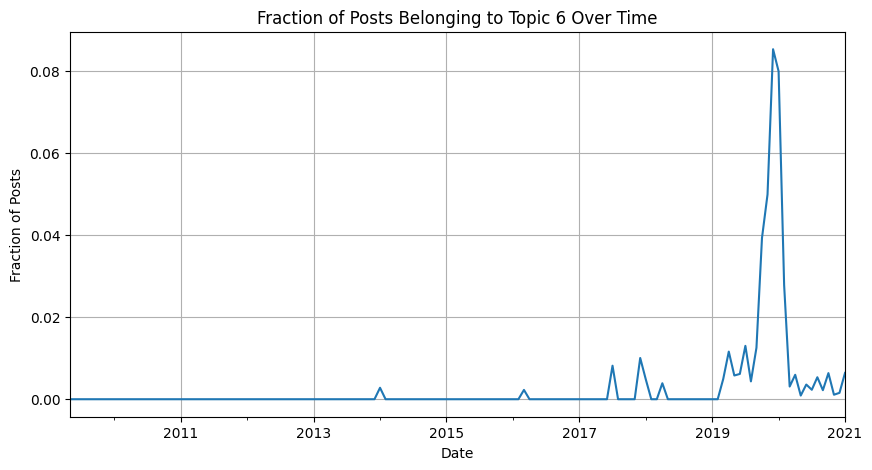

In [21]:
#Plot the frequency of a specific topic over time.
TOPIC = 6 #impeachment!

# Convert 'date' to datetime and set it as the index
df['date'] = pd.to_datetime(df['date'])
dff = df.set_index('date')

# Group by month and topic
monthly_topic_count = dff.groupby([pd.Grouper(freq='M'), 'topic']).size().unstack(fill_value=0)

# Calculate the fraction of posts that are topic 
monthly_topic_fraction = monthly_topic_count[TOPIC] / monthly_topic_count.sum(axis=1)

# Plotting
monthly_topic_fraction.plot(kind='line', figsize=(10, 5))
plt.title(f'Fraction of Posts Belonging to Topic {TOPIC} Over Time')
plt.ylabel('Fraction of Posts')
plt.xlabel('Date')
plt.grid(True)
plt.show()

# Machine Learning for text

Machine learning allows flexible annotation and prediction from textual data. It can be used for nearly any text analysis tasks. 

In our case, we will focus on whether there are differences in the messages when Trump posts from iPhone and Android. 

He began to post from iPhone when he started as President, and it seems these message might actually come from his aids.

We train machine learning to guess based on the text in the tweets whether he is sending the message from Android or iPhone. Can we predict it?

In [22]:
# !pip3 install scikit-learn


In [27]:
#We focus on the messages that are from iPhone or Android
df = pd.read_csv('trumptweets.csv')
df = df.loc[df['device'].isin(set(['Twitter for iPhone', 'Twitter for Android']))] 


In [28]:
# Preprocess the text as usual
df['text'] = df['text'].apply(clean_text).apply(case_normalization).apply(tokenization).apply(remove_stopwords).apply(lemmatize)

The following code:

1. Splits the dataset into training and testing sets.
2. Vectorizes the messages using a bag-of-words model, excluding common English stop words for more meaningful feature analysis.
3. Trains a RandomForestClassifier on the vectorized training data.
4. Predicts the device category on the test data and prints out the classification report and accuracy.
5. Extracts and prints the feature importances to see which words are the most discriminative in terms of predicting the device used.

The most important features output will give you insight into which words are more characteristic of messages sent from either iphone or android. Keep in mind that feature importance in random forests doesn't always equate to causality, and high importance might be due to correlation rather than a causal relationship.

In [29]:
# Train machine learning to identify 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Split the dataset into training and testing sets
# The text is what we use to try to predict the device. 
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['device'], test_size=0.3, random_state=42)

# Vectorize the text messages into a bag-of-words model
vectorizer = CountVectorizer(stop_words='english')
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Use a machine learning classifier, in this case, a Random Forest
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train_vectorized, y_train)

# Predict the device used for the test set
predictions = classifier.predict(X_test_vectorized)

## This is the end of the ML code. Easy, no?
#-------
##### The rest is printing and evaluation ####

# Evaluate the classifier
print(classification_report(y_test, predictions))
print("Accuracy:", accuracy_score(y_test, predictions))

# Get feature importances
feature_importances = classifier.feature_importances_
feature_names = vectorizer.get_feature_names_out()

# Map feature importances to their corresponding words
feature_importance_dict = {word: importance for word, importance in zip(feature_names, feature_importances)}

# Sort the words by their feature importance
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

# Print out the most important features (words)
# for word, importance in sorted_feature_importances[:20]:  # top 20 words
#     print(f"Word: {word}, Importance: {importance}")

# After fitting the CountVectorizer on the training set
X_vectorized = vectorizer.transform(df['text'])

# Create a DataFrame with the word counts
word_counts = pd.DataFrame(X_vectorized.toarray(), columns=vectorizer.get_feature_names_out())

# Add the device column back to the DataFrame
word_counts['device'] = df['device'].values

# Calculate the sum of word counts for each device
word_counts_sum = word_counts.groupby('device').sum()

# Now you can compare the word counts for each word in your feature importances list
for device in word_counts['device'].unique():
    print(f'\n {device}')
    for word, importance in sorted_feature_importances[:40]:  # top 20 words
        counts = word_counts_sum[word]
        more_common_in = counts.idxmax()
        if more_common_in == device:
            print(f"{word}, Importance: {importance}")

                     precision    recall  f1-score   support

Twitter for Android       0.92      0.85      0.89      4267
 Twitter for iPhone       0.93      0.96      0.95      8487

           accuracy                           0.93     12754
          macro avg       0.92      0.91      0.92     12754
       weighted avg       0.93      0.93      0.93     12754

Accuracy: 0.9261408185667241

 Twitter for iPhone
rt, Importance: 0.09219865618700993
https, Importance: 0.07479567686469239
democrats, Importance: 0.007854489610218278
fake, Importance: 0.004395329867710581
biden, Importance: 0.004356324246503931
news, Importance: 0.003770457493192382
whitehouse, Importance: 0.0037658816642760747
amp, Importance: 0.0032052454826699993
thank, Importance: 0.002850430960313691
president, Importance: 0.002721501564856787
great, Importance: 0.0026927675922088002
impeachment, Importance: 0.0025705125682693717
election, Importance: 0.002547904148514072
joe, Importance: 0.002355241776796686
obama,

### Exercise 5: Spam classifier - spam or ham?

Your task is to adapt the classifier above to identify if a text message is spam or not. 

We will us an existing database of text messages. 

How high accuracy can you achieve? 

In [147]:
# Load the spam file
df = pd.read_csv('spam.csv',encoding="ISO-8859-1")

In [148]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [149]:
# [YOUR CODE HERE]

[Go to Solution](#exercise5)

# Solutions

<a id="exercise1"></a>
## Solutions Exercise 1:  


In [ ]:
dd = df.sample(10)

# df.apply() is a quick way of applying functions to a dataframe column
print("Original")
print(list(dd.text))

print("Clean text!")
dd.text = dd.text.apply(clean_text)
print(list(dd.text))

print("Normalize!")
dd.text = dd.text.apply(case_normalization)
print(list(dd.text))

print("Tokenize!")
dd.text = dd.text.apply(tokenization)
print(list(dd.text))

print("Stop stopwords!")
dd.text = dd.text.apply(remove_stopwords)
print(list(dd.text))

print("Lemmatize!")
dd.text = dd.text.apply(lemmatize)
print(list(dd.text))

print("Finished.")

<a id="exercise2"></a>
## Solutions Exercise 2:


The best results for TF-IDF is to clean the data as much as possible. Apply all the steps from above!

In [66]:
# Let's read the dataframe from file again to reset any changes we've made to it.
df = pd.read_csv('trumptweets.csv')

# Group text by month
df['month'] = df.date.str[:7]+'-01'
grouped = df.groupby('month')['text'].apply(' '.join).reset_index()

# Preprocessing goes here: this just splits each document into tokens
grouped['tokens'] = grouped['text'].apply(clean_text).apply(case_normalization).apply(tokenization).apply(remove_stopwords).apply(lemmatize)
#SOLUTION (we can chain the apply commands)

#Calculate TF-IDF per month
grouped['tfidf'] = compute_tf_idf_manual(grouped['tokens'])

#Get the top-word 
grouped['tfidf_top']  = grouped['tfidf'].apply(get_highest_values)

# Print out year-by-year
grouped['year'] = grouped.month.str[:4]
for year in grouped.year.unique():
    gy = grouped.loc[grouped['year']==year]
    print(year, [a[0][0] for y,a in  zip(gy['month'],gy['tfidf_top'])])

2009 ['keychain', 'commercialfree', 'bookkeychain', 'bahamas', 'executeyou', 'jareds', 'bountiful', 'habitat']
2010 ['wahlberg', 'connector', 'casting', 'soho', 'bret', 'telethon', 'contest', 'wwwyoutubecomusermattressserta', 'whisperer', 'episode', 'susteren', 'hotel']
2011 ['cavuto', 'desk', 'trumproast', 'danmcisaac', 'vegasusa', 'campanella', 'johnboehner', 'trumpvlog', 'barackobama', 'barackobama', 'barackobama', 'timetogettough']
2012 ['cont', 'cont', 'cont', 'cont', 'sweepstweet', 'barackobama', 'barackobama', 'barackobama', 'mittromney', 'mittromney', 'mittromney', 'lordsugar']
2013 ['billmaher', 'thanks', 'celebapprentice', 'celebapprentice', 'realdonaldtrump', 'realdonaldtrump', 'realdonaldtrump', 'realdonaldtrump', 'realdonaldtrump', 'nymag', 'rspbscotland', 'mandela']
2014 ['realdonaldtrump', 'buzzfeed', 'oscar', 'nflcommish', 'realdonaldtrump', 'realdonaldtrump', 'realdonaldtrump', 'ebola', 'mikeandmike', 'ebola', 'realdonaldtrump', 'realdonaldtrump']
2015 ['apprenticenbc'

<a id="exercise3"></a>
## Solutions Exercise 3:


In [ ]:
import matplotlib.pyplot as plt

df = pd.read_csv('trumptweets.csv')

# -------
# Since VADER uses the structure of the sentence, we should NOT make any preprocessing!
# For instnace: if we remove "not", we'll get terrible results!
# So we simply apply the function on the text column:
df['sentiment'] = df['text'].apply(get_sentiment)
# -------

# Plot the sentiment over time graph
df['month'] = df.date.str[:7]+'-01'
df['month'] = pd.to_datetime(df['month']) 
fig, ax = plt.subplots(figsize=(8,5))

df.groupby(['month'])['sentiment'].mean().plot(ax=ax, marker='o', lw=1,label='Trump\'s mean mood')
    
ax.set_xlabel('Month')
ax.set_ylabel('Average Sentiment')
ax.set_title("Trump's Monthly Mood")

# Add vertical line
ax.axvline('2012-11-06', color='red', linestyle='--',label='Obama election')
ax.axvline('2016-11-08', color='green', linestyle='--',label='Trump election')
ax.axvline('2020-11-03', color='blue', linestyle='--',label='Biden election')

ax.grid(True)
fig.tight_layout()

plt.legend()
plt.show()



## Solutions Exercise 4:
<a id="exercise4"></a>


In [143]:
import pandas as pd
from gensim import corpora, models
import gensim

# Apply all preprocessing functions

# Create a dictionary and corpus needed for Topic Modeling
dictionary = corpora.Dictionary(processed_texts) 
corpus = [dictionary.doc2bow(text) for text in processed_texts] 

# LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Print the topics found by the LDA model
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.002*"miljöpartiet" + 0.001*"högerpartiets" + 0.001*"högerpartiet" + 0.001*"skattesänkningarna" + 0.001*"utgifter" + 0.001*"krävde" + 0.001*"tidtabell" + 0.000*"inkomsten" + 0.000*"budgetalternativet" + 0.000*"reserver"')
(1, '0.007*"vpk" + 0.002*"kommunisterna" + 0.001*"arbetande" + 0.001*"kamp" + 0.001*"parti" + 0.001*"kommunistiska" + 0.001*"enda" + 0.001*"arbetarklassens" + 0.001*"socialism" + 0.001*"storfinansens"')
(2, '0.018*"skall" + 0.006*"måste" + 0.003*"moderaterna" + 0.003*"socialism" + 0.002*"skatter" + 0.002*"mrdper" + 0.002*"moderata" + 0.002*"folkpartiet" + 0.002*"storfinansens" + 0.002*"arbetande"')
(3, '0.017*"sverige" + 0.015*"ska" + 0.011*"vill" + 0.007*"genom" + 0.006*"få" + 0.006*"svenska" + 0.006*"måste" + 0.004*"kunna" + 0.004*"därför" + 0.004*"får"')
(4, '0.012*"skall" + 0.006*"folkpartiet" + 0.004*"folkpartiets" + 0.003*"eg" + 0.002*"foer" + 0.002*"vill" + 0.002*"glömda" + 0.001*"a" + 0.001*"frihet" + 0.001*"pa"')
(5, '0.021*"bör" + 0.006*"måste" + 0.003

## Solutions Exercise 5:
<a id="exercise5"></a>


We can use almost exactly the same code as for the Trump tweets

In [154]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Data preparation
df = pd.read_csv('spam.csv',encoding="ISO-8859-1")

texts = np.array(df['v2'])
labels = np.array([0 if t=='ham' else 1 if t=='spam' else None for t in df['v1']])  # 1 - spam, 0 - not spam

# Vectorization
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(texts)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42)

# Model training
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluation
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1453
           1       1.00      0.81      0.90       219

    accuracy                           0.98      1672
   macro avg       0.99      0.91      0.94      1672
weighted avg       0.98      0.98      0.97      1672



#